In [2]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 4.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 4.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


In [3]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 4.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]


In [13]:
!pip install seaborn

In [1]:
import hdf5_getters as GETTERS
import h5py
import glob
from pyspark.sql import SparkSession
import pyspark
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.types import StructType, StructField, DoubleType, StringType

import numpy as np
import hdf5_getters as GETTERS
import h5py
import glob
import pandas as pd
# import matplotlib

#### 1. Crear la sesión con SPARK

In [2]:

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName('XML ETL') \
    .master("local[*]") \
    .config('job.local.dir', 'file:/models/music-recommender-model') \
    .getOrCreate()

df = spark.range(10).toDF("number")
df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/16 14:44:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+------+
|number|
+------+
|     0|
|     1|
|     2|
|     3|
|     4|
|     5|
|     6|
|     7|
|     8|
|     9|
+------+



In [19]:
# Stop Spark session
spark.stop()

In [15]:
df_test = spark.range(10)  # 1 millón de filas
print(df_test.count())  # Debe devolver 1,000,000

10


#### 2 - Carga del Dataset y Limpieza

In [3]:
df = spark.read.parquet("/opt/bitnami/spark/datasets/millionsong.parquet")

In [4]:
from pyspark.sql.functions import col, sin, cos, lit, when
import math

# 1. Eliminar columna 'danceability' si está presente
df = df.drop("danceability")

# 2. Filtrar tempo razonable
df = df.filter((col("tempo") >= 40) & (col("tempo") <= 250))

# 3. Filtrar time_signature válidos (1–5)
df = df.filter((col("time_signature") >= 1) & (col("time_signature") <= 5))

# 4. Codificar circularmente 'key'
df = df.withColumn("key_sin", sin(2 * math.pi * col("key") / lit(12)))
df = df.withColumn("key_cos", cos(2 * math.pi * col("key") / lit(12)))

# 5. Transformar 'loudness' a positivo para mejor escalado
min_loudness = df.select("loudness").agg({"loudness": "min"}).collect()[0][0]
df = df.withColumn("loudness_pos", col("loudness") + abs(min_loudness) + 1)

# 6. Crear 'mode_major' binaria por claridad
df = df.withColumn("mode_major", when(col("mode") == 1, 1).otherwise(0))


#### Entrenar el Modelo

In [5]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.sql.functions import col, expr
from pyspark.ml.functions import vector_to_array, array_to_vector

# 1. Definir columnas a usar
feature_cols = ['tempo', 'loudness_pos', 'key_sin', 'key_cos', 'mode_major', 'time_signature']

# 2. VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vec")
df_assembled = assembler.transform(df)

# 3. Escalado estándar
scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features")
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# 4. Convertir a array y aplicar pesos personalizados
df_scaled = df_scaled.withColumn("scaled_array", vector_to_array("scaled_features"))

# 5. Aplicar pesos manuales (deben coincidir en orden con feature_cols)
# weights = [1.5, 1.0, 2.0, 2.0, 1.0, 1.0] 
# weights = [5.0, 1.0, 2.5, 2.5, 0.5, 0.5]
# weights = [3.0, 1.0, 3.0, 3.0, 0.5, 0.5] #k=10, silhouette_score=0.4511
# weights=[4.0, 1.0, 3.0, 3.0, 0.5, 0.5] # k=12, silhouette_score=0.4593
# weights=[4.0, 1.0, 3.5, 3.5, 0.5, 0.5] # k=10, silhouette_score=0.4617
# weights=[4.5, 1.0, 3.5, 3.5, 0.5, 0.5] # k=14, silhouette_score=0.4745
# weights=[4.5, 1.0, 4.0, 4.0, 0.5, 0.5]  # k=13, silhouette_score=0.4833
# weights=[4.5, 1.0, 4.5, 4.5, 0.5, 0.5] # k=12, silhouette_score=0.4852
weights = [4.5, 1.0, 5.0, 5.0, 0.5, 0.5] #k=11, silhouette_score=0.4867


# weights = [2.0, 1.0, 3.0, 3.0, 0.5, 0.5] #048
# weights = [4.0, 1.5, 3.5, 3.5, 1.0, 0.5]
# weights = [2.5, 1.0, 2.0, 2.0, 1.0, 0.5]


weighted_expr = f"transform(scaled_array, (x, i) -> x * array({','.join(map(str, weights))})[i])"
df_weighted = df_scaled.withColumn("weighted_scaled_features", array_to_vector(expr(weighted_expr)))

# 6. KMeans clustering con k=10
kmeans = KMeans(
    featuresCol='weighted_scaled_features',
    predictionCol='cluster_id',
    k=11,
    seed=42
)
model = kmeans.fit(df_weighted)

# 7. Asignar cluster
df_with_cluster = model.transform(df_weighted)

# 8. Ver resultados
df_with_cluster.select("title", "artist", "cluster_id").show(10, truncate=False)


25/07/16 14:44:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/07/16 14:44:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+--------------------------------+---------------------------------+----------+
|title                           |artist                           |cluster_id|
+--------------------------------+---------------------------------+----------+
|Scream                          |Adelitas Way                     |6         |
|A Poor Recipe For Civic Cohesion|Western Addiction                |9         |
|I Didn't Mean To                |Casual                           |6         |
|The Lark In The Clear Air       |Alquimia                         |3         |
|Soul Deep                       |The Box Tops                     |9         |
|Hit Da Scene                    |Quest_ Pup_ Kevo                 |1         |
|Come On (Album Version)         |Super Deluxe                     |10        |
|Heartache People                |Big Brother & The Holding Company|1         |
|Andalucia                       |Stanley Black                    |3         |
|Amor De Cabaret                 |Sonora

In [28]:
df_scaled.show(1)

+------------------+------+------------+------+---+----+--------------+--------+-------------------+------------------+------------------+----------+--------------------+--------------------+--------------------+
|           song_id| title|      artist| tempo|key|mode|time_signature|loudness|            key_sin|           key_cos|      loudness_pos|mode_major|        features_vec|     scaled_features|        scaled_array|
+------------------+------+------------+------+---+----+--------------+--------+-------------------+------------------+------------------+----------+--------------------+--------------------+--------------------+
|SOBLFFE12AF72AA5BA|Scream|Adelitas Way|99.944|  1|   1|             4|  -4.769|0.49999999999999994|0.8660254037844387|54.186001777648926|         1|[99.9440002441406...|[2.95802026947342...|[2.95802026947342...|
+------------------+------+------------+------+---+----+--------------+--------+-------------------+------------------+------------------+----------

#### Recomendación 

In [30]:
import numpy as np
import pandas as pd
from pyspark.sql.functions import col, expr
from pyspark.ml.functions import vector_to_array, array_to_vector

# Definir pesos (deben coincidir con el orden de feature_cols)
weights = [5.0, 1.0, 2.0, 2.0, 0.5, 0.5]
weight_expr = f"transform(scaled_array, (x, i) -> x * array({','.join(map(str, weights))})[i])"

new_song = {
    'tempo': 120.0,
    'loudness_pos': 5.0,
    'key': 2.0,
    'mode': 1.0,
    'time_signature': 4.0
}

# Calcular key_sin y key_cos
new_song['key_sin'] = np.sin(2 * np.pi * new_song['key'] / 12)
new_song['key_cos'] = np.cos(2 * np.pi * new_song['key'] / 12)
new_song['mode_major'] = 1.0 if new_song['mode'] == 1 else 0.0

# Eliminar campos no usados
del new_song['key']
del new_song['mode']

# Convertir a Spark DataFrame
new_song_df_pd = pd.DataFrame([new_song])
new_song_df = spark.createDataFrame(new_song_df_pd)

# Ensamblar y escalar
new_song_vec = assembler.transform(new_song_df)
new_song_scaled = scaler_model.transform(new_song_vec)

# Aplicar pesos
new_song_scaled = new_song_scaled.withColumn("scaled_array", vector_to_array("scaled_features"))
new_song_weighted = new_song_scaled.withColumn("weighted_scaled_features", array_to_vector(expr(weight_expr)))

# Predecir cluster
new_song_pred = model.transform(new_song_weighted)
predicted_cluster = new_song_pred.select("cluster_id").collect()[0]["cluster_id"]
print(f"La nueva canción ha sido asignada al clúster: {predicted_cluster}")

# Buscar canciones similares del dataset original
similar_songs = df_with_cluster.filter(df_with_cluster.cluster_id == predicted_cluster)

# Mostrar algunas recomendaciones
similar_songs.select("title", "artist", "cluster_id").limit(5).show(truncate=False)


La nueva canción ha sido asignada al clúster: 0
+-----------------------------------------+---------------+----------+
|title                                    |artist         |cluster_id|
+-----------------------------------------+---------------+----------+
|What Makes Us Tick (Live) (Album Version)|Biohazard      |0         |
|Come With Me                             |Gleave         |0         |
|Stop Laughing                            |Moose          |0         |
|Arms and Armour                          |Sofia Talvik   |0         |
|Catwalk (Black Ink Mix)                  |Tangerine Dream|0         |
+-----------------------------------------+---------------+----------+



In [14]:
metadata_df = pd.read_csv("songs_metadata.csv")

# Supongamos que estos son los song_ids recomendados que has obtenido de tu modelo
recommended_song_ids = [row['song_id']
                        for row in similar_songs.select("song_id").limit(3).collect()]


# Filtramos los metadatos para obtener nombre de la canción y artista
recommended_songs = metadata_df[metadata_df['song_id'].isin(
    recommended_song_ids)]

# Mostramos el resultado
print(recommended_songs[['song_id', 'title', 'artist']])

                song_id                              title           artist
0    SOZECOE12AB017E615  Diamonds Are A Girl's Best Friend  Gloria De Haven
84   SOPJEXC12A6D4FB529                Hot Dental Supplies      Marga Gomez
149  SOJXYFD12A8C143701         The Ferocious O' Flahertys       Joe Heaney


#### Guardar el modelo

In [31]:
# Guardar ensamblador
assembler.write().overwrite().save("file:///models/music-recommender-model/assembler")

# Guardar scaler entrenado (no el scaler base)
scaler_model.write().overwrite().save("file:///models/music-recommender-model/scaler")

# Guardar modelo KMeans entrenado
model.write().overwrite().save("file:///models/music-recommender-model/kmeans")



##### Guardar las canciones y a que cluster pertenecen

In [7]:
df_with_cluster.show(5)

+------------------+--------------------+-----------------+-------+---+----+--------------+--------+--------------------+-------------------+------------------+----------+--------------------+--------------------+--------------------+------------------------+----------+
|           song_id|               title|           artist|  tempo|key|mode|time_signature|loudness|             key_sin|            key_cos|      loudness_pos|mode_major|        features_vec|     scaled_features|        scaled_array|weighted_scaled_features|cluster_id|
+------------------+--------------------+-----------------+-------+---+----+--------------+--------+--------------------+-------------------+------------------+----------+--------------------+--------------------+--------------------+------------------------+----------+
|SOBLFFE12AF72AA5BA|              Scream|     Adelitas Way| 99.944|  1|   1|             4|  -4.769| 0.49999999999999994| 0.8660254037844387|54.186001777648926|         1|[99.944000244140

In [8]:
df_export = df_with_cluster.select("title", "artist", "tempo", "key", "mode", "cluster_id")
# df_export.write.csv("songs_with_cluster", header=True, mode="overwrite")

In [9]:
df_export.toPandas().to_csv("songs_with_cluster.csv", index=False)

#### Cargar el Modelo

In [5]:
from pyspark.ml import PipelineModel

loaded_model = PipelineModel.load("file:///models/music-recommender-model")

In [6]:
# Crear nueva canción con timbre simulado
new_song = {
    'tempo': 120.0,
    'loudness': -5.0,
    'danceability': 60,
    'key': 2.0,
    'mode': 1.0,
    'time_signature': 4.0,
    'track_name': 'New Song',
    'artist_name': 'Unknown Artist'
}



# Convertir a DataFrame de Spark
df_new = spark.createDataFrame(pd.DataFrame([new_song]))

# Predecir cluster directamente con el pipeline
predicted = loaded_model.transform(df_new)
predicted_cluster = predicted.select("cluster_id").collect()[0]["cluster_id"]

print(f"La canción fue asignada al cluster {predicted_cluster}")

df_with_clusters = loaded_model.transform(df_scaled)

recommendations = df_with_clusters.filter(
    df_with_clusters.cluster_id == predicted_cluster
).select("track_name", "artist_name").limit(3)

recommendations.show()


IllegalArgumentException: duration does not exist. Available: tempo, loudness, danceability, key, mode, time_signature, track_name, artist_name

In [15]:
metadata_df = pd.read_csv("songs_metadata.csv")

# Supongamos que estos son los song_ids recomendados que has obtenido de tu modelo
recommended_song_ids = [row['song_id']
                        for row in similar_songs.select("song_id").limit(3).collect()]


# Filtramos los metadatos para obtener nombre de la canción y artista
recommended_songs = metadata_df[metadata_df['song_id'].isin(
    recommended_song_ids)]

# Mostramos el resultado
print(recommended_songs[['song_id', 'title', 'artist']])

               song_id           title              artist
19  SOQBCSM12AC4687CDE  Pete's Crusade  Light Of The World


### Mejorar el modelo (Métricas)

In [42]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(
    featuresCol='weighted_scaled_features',
    predictionCol='cluster_id',
    metricName='silhouette',
    distanceMeasure='squaredEuclidean'
)

silhouette = evaluator.evaluate(df_with_cluster)
print(f"Silhouette score (k=10): {silhouette}")

Silhouette score (k=10): 0.339220173858087


In [132]:
ks = list(range(4, 20))  # Por ejemplo, de 2 a 30 clusters
df_for_clustering = df_weighted.select("weighted_scaled_features")

for k in ks:
    kmeans = KMeans(featuresCol='weighted_scaled_features', predictionCol='cluster_id', k=k, seed=42)
    model = kmeans.fit(df_for_clustering)
    df_clusters = model.transform(df_for_clustering)

    silhouette = evaluator.evaluate(df_clusters)
    print(f"k={k}, silhouette_score={silhouette:.4f}")

k=4, silhouette_score=0.4770


k=5, silhouette_score=0.4769


k=6, silhouette_score=0.4638


k=7, silhouette_score=0.4630


k=8, silhouette_score=0.4724


k=9, silhouette_score=0.4393


k=10, silhouette_score=0.4850


k=11, silhouette_score=0.4867


k=12, silhouette_score=0.4849


k=13, silhouette_score=0.4723


ERROR:root:KeyboardInterrupt while sending command.==========>      (7 + 1) / 8]
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

#### Que faeatures son más significativas

In [19]:
from pyspark.ml.feature import PCA

pca = PCA(k=5, inputCol="scaled_features", outputCol="pca_features")
model = pca.fit(df_scaled)
explained = model.explainedVariance.toArray()

for i, var in enumerate(explained):
    print(f"PC{i+1}: {var:.4f}")



PC1: 0.2550
PC2: 0.2321
PC3: 0.1950
PC4: 0.1605
PC5: 0.1574


In [10]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 5.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 5.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.8 MB/s eta 0:00:00-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 5.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


### Visualizar clusters

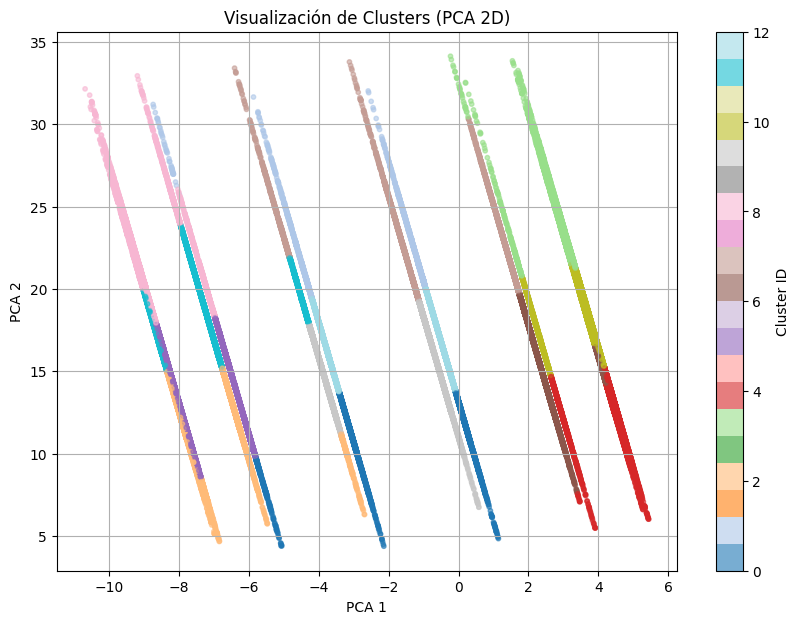

In [129]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

# Paso 1: Asegurarse de tener el DF con los clusters
# (df_with_cluster ya lo tienes con la columna 'cluster_id')

# Paso 2: Aplicar PCA para reducir a 2 dimensiones
# Paso 1: PCA sobre las features ESCALADAS, sin pesos
pca = PCA(k=2, inputCol="weighted_scaled_features", outputCol="pca_features")

# pca = PCA(k=2, inputCol="weighted_scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_with_cluster)
df_pca = pca_model.transform(df_with_cluster)

# Paso 3: Convertir a Pandas para graficar
df_sampled = df_pca.sample(fraction=0.05, seed=42)  # por ejemplo 5%
df_plot = df_sampled.select("pca_features", "cluster_id").toPandas()
# df_plot = df_pca.select("pca_features", "cluster_id").toPandas()

# Extraer coordenadas PCA
pca_values = df_plot["pca_features"].apply(lambda x: x.toArray())
pca_2d = np.stack(pca_values.values)
x, y = pca_2d[:, 0], pca_2d[:, 1]



# Paso 4: Graficar con colores por cluster
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x, y, c=df_plot["cluster_id"], cmap="tab20", s=10, alpha=0.6)
plt.title("Visualización de Clusters (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()


In [ ]:
!pip install scikit-learn

In [10]:
# Suponiendo que ya tienes entrenado tu modelo como 'model'
centroids = model.clusterCenters()

# Imprimir los centroides
for i, center in enumerate(centroids):
    print(f"Centroide {i}: {center}")


Centroide 0: [20.76985132  9.65593636  5.36466615 -4.14339607  0.59548561  1.58001321]
Centroide 1: [21.71212767  9.74212164 -3.3431575  -5.66376407  0.79081713  1.59677311]
Centroide 2: [23.66578629  9.71785849  4.67338911  4.5440572   0.83742975  1.56212085]
Centroide 3: [14.34948938  9.41226436  6.56893252  2.69913437  0.82748315  1.57403559]
Centroide 4: [14.40415559  9.52115999 -7.03435174 -1.07621856  0.67845667  1.59030094]
Centroide 5: [18.1591165   9.6696081   1.28572618  6.53894763  0.84849448  1.63250098]
Centroide 6: [12.40382834  9.37253309  1.41880976  6.4863216   0.83109152  1.57543637]
Centroide 7: [22.36643732  9.74490943 -6.07848183  2.57159296  0.55540381  1.58511656]
Centroide 8: [14.69421699  9.58999438 -4.80622538  4.88143581  0.44635597  1.63510497]
Centroide 9: [14.08918894  9.52622133 -2.46089272 -6.2447386   0.77529403  1.6117312 ]
Centroide 10: [13.42502097  9.37143296  5.02357425 -4.67835844  0.61683426  1.58368235]


In [53]:
cluster_distribution = df_with_cluster.groupBy("cluster_id").count().orderBy("cluster_id")
cluster_distribution.show()

+----------+------+
|cluster_id| count|
+----------+------+
|         0| 73085|
|         1|112046|
|         2| 33701|
|         3| 72783|
|         4|121148|
|         5|133770|
|         6| 75462|
|         7|103059|
|         8|125050|
|         9| 36295|
|        10| 82580|
+----------+------+



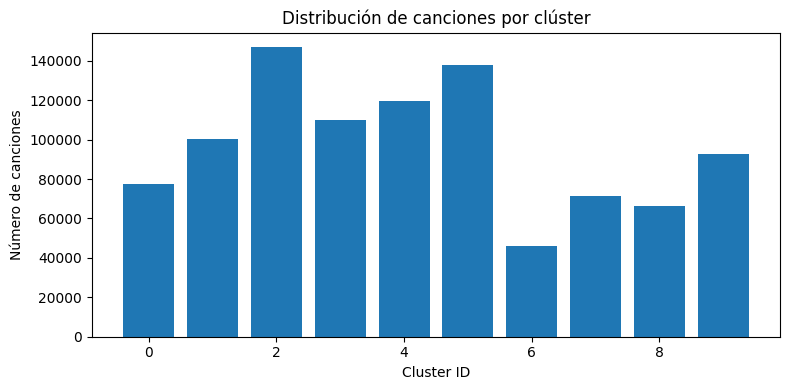

In [34]:
pdf = cluster_distribution.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(pdf['cluster_id'], pdf['count'])
plt.xlabel("Cluster ID")
plt.ylabel("Número de canciones")
plt.title("Distribución de canciones por clúster")
plt.tight_layout()
plt.show()

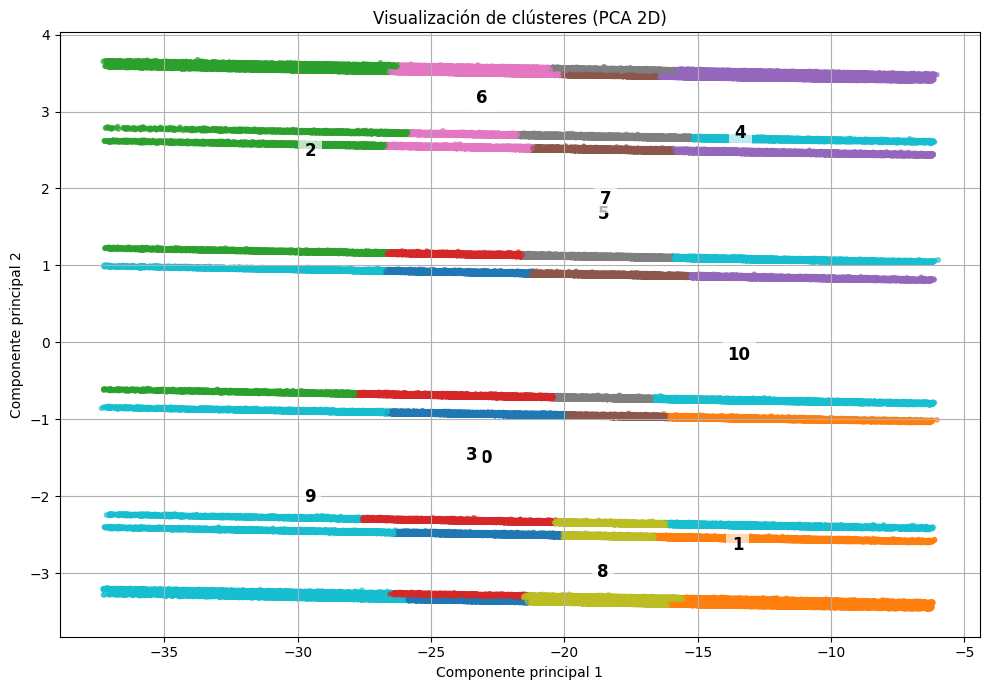

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Paso 1: Obtener el PCA como ya haces
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="weighted_scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_with_cluster)
df_pca = pca_model.transform(df_with_cluster)

# Paso 2: Convertir a Pandas
df_plot = df_pca.select("pca_features", "cluster_id").toPandas()

# Paso 3: Extraer coordenadas PCA
pca_values = df_plot["pca_features"].apply(lambda x: x.toArray())
pca_2d = np.stack(pca_values.values)
x, y = pca_2d[:, 0], pca_2d[:, 1]
cluster_ids = df_plot["cluster_id"].values

# Paso 4: Calcular centroide visual por clúster
import pandas as pd
df_plot_xy = pd.DataFrame({'x': x, 'y': y, 'cluster_id': cluster_ids})

centroids_visuales = df_plot_xy.groupby('cluster_id')[['x', 'y']].mean().reset_index()

# Paso 5: Plotear
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x, y, c=cluster_ids, cmap='tab10', s=10, alpha=0.6)

# Añadir etiquetas en los centroides visuales
for _, row in centroids_visuales.iterrows():
    plt.text(row['x'], row['y'], str(int(row['cluster_id'])), fontsize=12, fontweight='bold', 
             ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title("Visualización de clústeres (PCA 2D)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()


#### TSNE

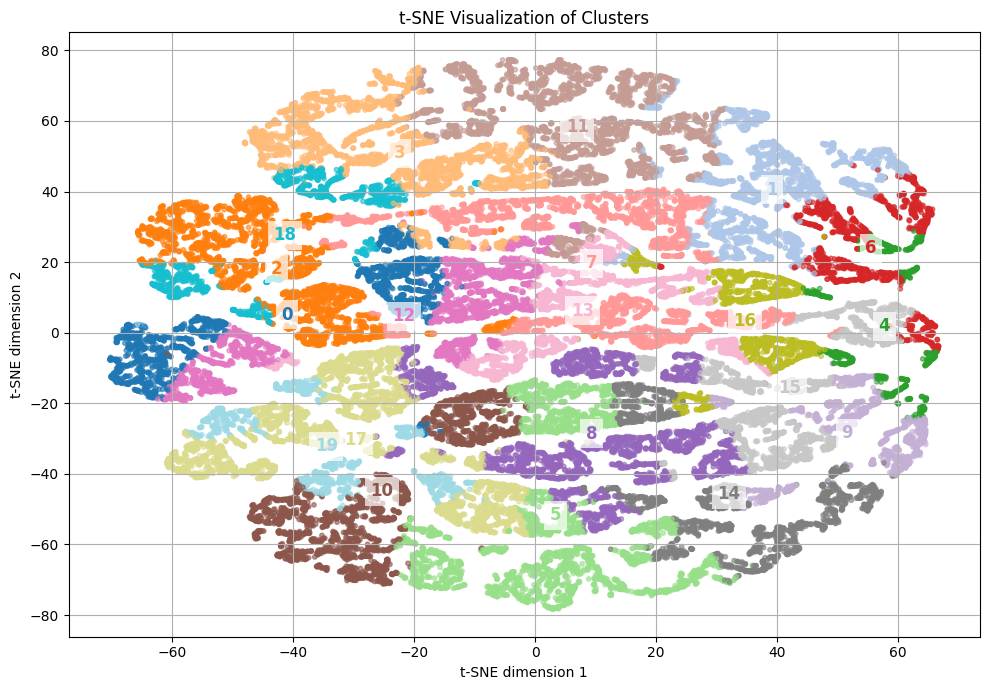

In [71]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Muestra del 5% del dataset original con clusters
df_sampled = df_with_cluster.sample(fraction=0.05, seed=42)

# Convertimos a Pandas para aplicar t-SNE
df_tsne_input = df_sampled.select("weighted_scaled_features", "cluster_id").toPandas()
X = np.stack(df_tsne_input["weighted_scaled_features"].apply(lambda v: v.toArray()))
y = df_tsne_input["cluster_id"].values

# Aplicar t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_features = tsne.fit_transform(X)

# Crear DataFrame para visualización
df_vis = pd.DataFrame({
    "x": tsne_features[:, 0],
    "y": tsne_features[:, 1],
    "cluster_id": y
})

# Calcular centroides visuales
centroids = df_vis.groupby("cluster_id")[["x", "y"]].mean().reset_index()

# Visualización
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_vis["x"], df_vis["y"], c=df_vis["cluster_id"], cmap="tab20", s=10, alpha=0.6)

# Etiquetas con colores correspondientes
colors = [plt.colormaps['tab20'](i) for i in range(20)]

for _, row in centroids.iterrows():
    cluster_id = int(row["cluster_id"])
    cluster_color = colors[cluster_id % 20]  # Evitar error si cluster_id > 19
    plt.text(row["x"], row["y"], str(cluster_id), fontsize=12, fontweight="bold",
             ha="center", va="center", color=cluster_color,
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()


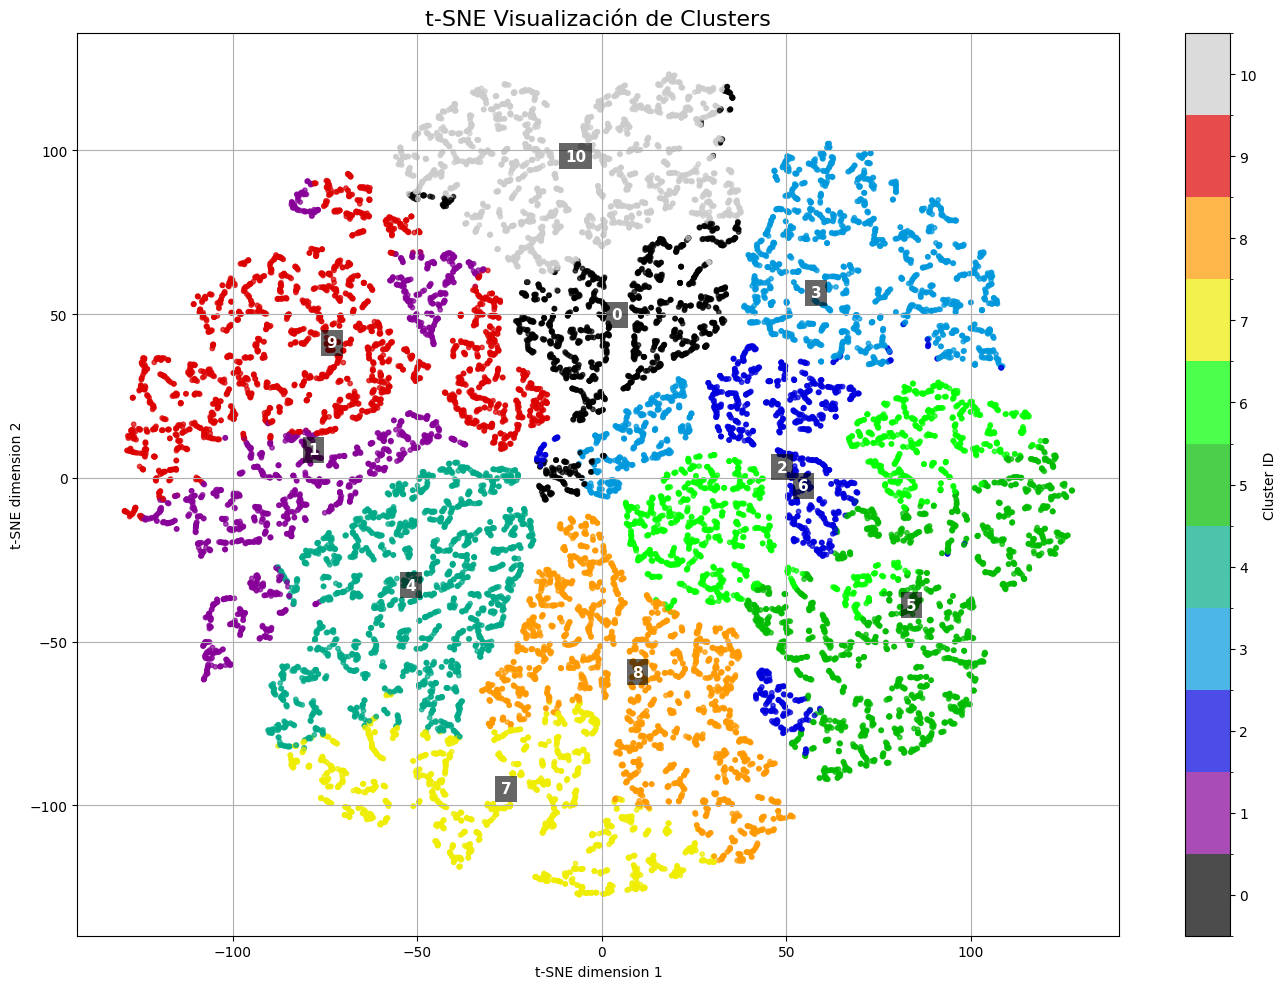

In [26]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np

# 1. Clusters únicos
unique_clusters = sorted(df_vis["cluster_id"].unique())
num_clusters = len(unique_clusters)

# 2. Generar colores discretos desde 'nipy_spectral'
base_cmap = plt.get_cmap('nipy_spectral')
colors = base_cmap(np.linspace(0, 1, num_clusters))  # tomamos colores vivos del gradiente
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=np.arange(num_clusters + 1) - 0.5, ncolors=num_clusters)

# 3. Visualización
plt.figure(figsize=(14, 10))
scatter = plt.scatter(df_vis["x"], df_vis["y"],
                      c=df_vis["cluster_id"],
                      cmap=cmap,
                      norm=norm,
                      s=10,
                      alpha=0.7)

cbar = plt.colorbar(scatter, ticks=unique_clusters)
cbar.set_label("Cluster ID")
cbar.set_ticks(unique_clusters)

# 4. Centroides + etiquetas (opcional)
for _, row in centroids.iterrows():
    plt.annotate(str(int(row["cluster_id"])), 
                 (row["x"], row["y"]),
                 textcoords="offset points", 
                 xytext=(0, 5), ha='center',
                 fontsize=11, weight="bold",
                 bbox=dict(facecolor='black', alpha=0.6, edgecolor='none'),
                 color='white')

plt.title("t-SNE Visualización de Clusters", fontsize=16)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("tsne_clusters_nipy_discrete.png", dpi=300, bbox_inches="tight")
plt.savefig("tsne_clusters_nipy_discrete.svg", format="svg", bbox_inches="tight")
plt.show()


/tmp/ipykernel_40/764613823.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)  # paleta más equilibrada


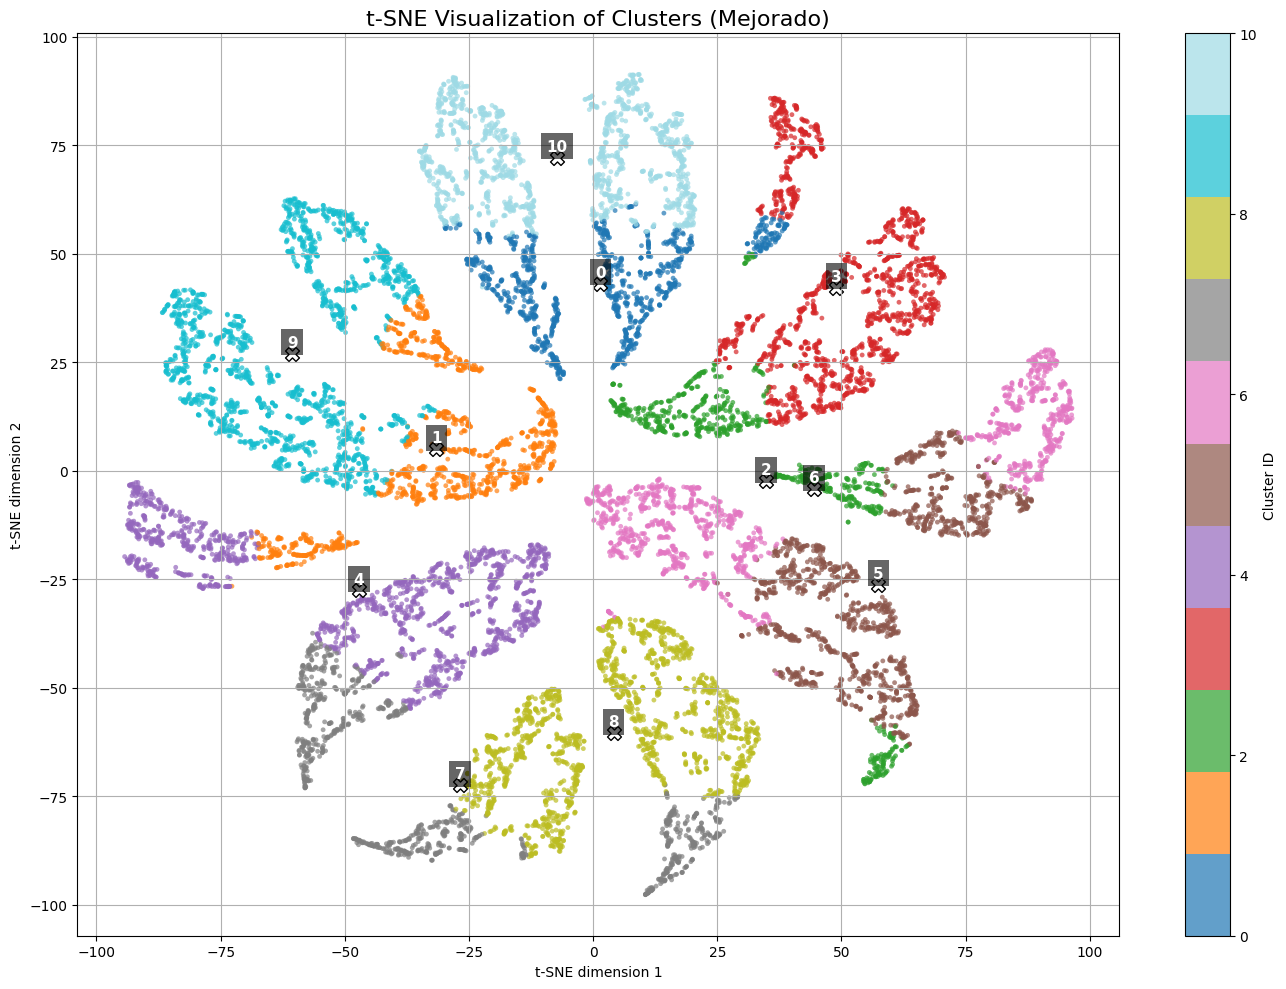

In [139]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

# 1. Muestra aleatoria del 1.5%
df_sampled = df_with_cluster.sample(fraction=0.015, seed=42)

# 2. Convertimos a Pandas para aplicar t-SNE
df_tsne_input = df_sampled.select("weighted_scaled_features", "cluster_id").toPandas()
X = np.stack(df_tsne_input["weighted_scaled_features"].apply(lambda v: v.toArray()))
y = df_tsne_input["cluster_id"].values

# 3. Aplicar t-SNE con parámetros optimizados
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    init='pca',
    random_state=42
)
tsne_features = tsne.fit_transform(X)

# 4. Crear DataFrame para visualización
df_vis = pd.DataFrame({
    "x": tsne_features[:, 0],
    "y": tsne_features[:, 1],
    "cluster_id": y
})

# 5. Calcular centroides visuales
centroids = df_vis.groupby("cluster_id")[["x", "y"]].mean().reset_index()

# 6. Visualización
plt.figure(figsize=(14, 10))
num_clusters = df_vis["cluster_id"].nunique()
cmap = cm.get_cmap('tab20', num_clusters)  # paleta más equilibrada

# Puntos
scatter = plt.scatter(
    df_vis["x"],
    df_vis["y"],
    c=df_vis["cluster_id"],
    cmap=cmap,
    s=12,
    alpha=0.7,
    linewidths=0
)

# Centroides como 'X'
plt.scatter(
    centroids["x"],
    centroids["y"],
    c="white",
    edgecolors="black",
    s=100,
    marker='X',
    label="Centroides"
)

# Etiquetas encima de centroides
for _, row in centroids.iterrows():
    plt.annotate(str(int(row["cluster_id"])),
                 (row["x"], row["y"]),
                 textcoords="offset points",
                 xytext=(0, 5), ha='center',
                 fontsize=11, weight="bold",
                 bbox=dict(facecolor='black', alpha=0.6, edgecolor='none'),
                 color='white')

# Estética final
plt.title("t-SNE Visualization of Clusters", fontsize=16)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.tight_layout()

# Guardado en alta calidad
plt.savefig("tsne_clusters_sampled.png", dpi=300, bbox_inches="tight")
plt.savefig("tsne_clusters_sampled.svg", format="svg", bbox_inches="tight")
plt.show()


<Figure size 640x480 with 0 Axes>

In [46]:
import sklearn
print(sklearn.__version__)

1.7.0


In [ ]:
import pandas as pd
import sweetviz as sv

df = pd.read_parquet("/opt/bitnami/spark/datasets/millionsong.parquet")
# Crear análisis
report = sv.analyze([df, "Canciones"])
# Mostrar en el navegador o notebook
report.show_html("reporte_sweetviz.html")

In [136]:
df_with_cluster.groupBy("cluster_id").avg("tempo", "loudness", "key", "mode", "time_signature").orderBy("cluster_id").show()

+----------+------------------+-------------------+-------------------+-------------------+-------------------+
|cluster_id|        avg(tempo)|      avg(loudness)|           avg(key)|          avg(mode)|avg(time_signature)|
+----------+------------------+-------------------+-------------------+-------------------+-------------------+
|         0| 156.3301698264624| -9.551078171658519| 4.3140679533454644| 0.5621364436357128| 3.4774035736658413|
|         1|163.02171314301222|  -9.10432677529674|    6.9630568396722| 0.7455085101912167| 3.5144594452616094|
|         2|176.96650966518948| -9.224795092346728| 1.4330875387730084| 0.7888705213692676|  3.439792715317892|
|         3| 107.5538160218154|-10.801456802857102|  2.214302717714739| 0.7797659194604245| 3.4642134497123585|
|         4|108.15344929034181|-10.234806311674605|  8.686294298370964| 0.6396023863961132| 3.5002679336953415|
|         5|135.52795650593387|  -9.49382976369108|0.34516218464097587| 0.8008146552643365|  3.594335800

In [137]:
from pyspark.sql import functions as F

# Calcular min, max y avg por cluster
stats = (
    df_with_cluster
    .groupBy("cluster_id")
    .agg(
        F.avg("tempo").alias("avg_tempo"),
        F.min("tempo").alias("min_tempo"),
        F.max("tempo").alias("max_tempo"),
        
        F.avg("loudness").alias("avg_loudness"),
        F.min("loudness").alias("min_loudness"),
        F.max("loudness").alias("max_loudness"),
        
        F.avg("key").alias("avg_key"),
        F.min("key").alias("min_key"),
        F.max("key").alias("max_key"),
        
        F.avg("mode").alias("avg_mode"),
        F.min("mode").alias("min_mode"),
        F.max("mode").alias("max_mode"),
        
        F.avg("time_signature").alias("avg_time_signature"),
        F.min("time_signature").alias("min_time_signature"),
        F.max("time_signature").alias("max_time_signature")
    )
    .orderBy("cluster_id")
)

stats.show(truncate=False)


+----------+------------------+---------+---------+-------------------+------------+------------+-------------------+-------+-------+-------------------+--------+--------+------------------+------------------+------------------+
|cluster_id|avg_tempo         |min_tempo|max_tempo|avg_loudness       |min_loudness|max_loudness|avg_key            |min_key|max_key|avg_mode           |min_mode|max_mode|avg_time_signature|min_time_signature|max_time_signature|
+----------+------------------+---------+---------+-------------------+------------+------------+-------------------+-------+-------+-------------------+--------+--------+------------------+------------------+------------------+
|0         |156.3301698264624 |127.044  |249.952  |-9.551078171658519 |-54.477     |3.634       |4.3140679533454644 |3      |5      |0.5621364436357128 |0       |1       |3.4774035736658413|1                 |5                 |
|1         |163.02171314301222|133.458  |249.868  |-9.10432677529674  |-57.955     |

In [138]:
df_with_cluster.groupBy("cluster_id").count().orderBy("count", ascending=False).show()

+----------+------+
|cluster_id| count|
+----------+------+
|         9|119149|
|         4|111968|
|         8|107197|
|         3|100820|
|         5| 93782|
|        10| 88136|
|         6| 82973|
|         1| 76144|
|         7| 67925|
|         0| 67046|
|         2| 53839|
+----------+------+



### búsqueda de pesos

In [ ]:
from itertools import product
df_test = df_with_cluster.sample(fraction=0.05, seed=42)

# Rango de pesos a probar por feature
tempo_w     = [1.0, 2.0, 3.0]
loudness_w  = [0.5, 1.0]
key_w       = [1.0, 2.0]
mode_w      = [0.5, 1.0]
time_w      = [0.5]

best_score = -1
best_weights = None

for weights in product(tempo_w, loudness_w, key_w, key_w, mode_w, time_w):
    # Asignar los pesos (asumiendo [tempo, loudness, key_sin, key_cos, mode, time_signature])
    weighted_df = apply_weights(df_scaled, weights)  # función que tú ya tienes
    
    model = KMeans(featuresCol="weighted_scaled_features", k=6, seed=42).fit(weighted_df)
    df_clusters = model.transform(weighted_df)
    score = evaluator.evaluate(df_clusters)
    
    print(f"Weights: {weights}, silhouette: {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_weights = weights

print(f"\n Best weights: {best_weights} with silhouette {best_score:.4f}")
